# Image Classification using Transfer Learning in Neural Networks
- This tutorial covers developing a neural network model that combines the architecture and weights of a pre-trained model, `InceptionV3` model, in this case, with a few newly added layers to classify image data. All model development has been done under `Tensorflow` framework.
- [Animals 151](https://www.kaggle.com/datasets/sharansmenon/animals141) dataset from Kaggle website has been taken for model development. I have purposefully selected images for only 12 animal species(Elephant,Firefox,Fox,Gavial,Giraffe,Gorilla,Iguana,Leopard,Lion,Macao,Tiger,Wolf) as model development data.
- In this notebook, the classification model will be trained to identify between only **2 randomly selected species** out of the 12 species.

In [ ]:
# importing libraries necessary for data transformation, data pre-processing, model development etc

import os
import glob
import random
import zipfile
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from PIL import Image
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

### 1. Data import and Target definition

In [ ]:
# extracting all the images

zip_ref = zipfile.ZipFile('/content/Animals.zip', 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [ ]:
# extracting name of animals from folder name and defining Y/Target classess in dictionary

base_dir = '/content/tmp/Animals'
print(os.listdir(base_dir))

['Leopard', 'Wolf', 'Iguana', 'Gavial', 'Tiger', 'Elephant', 'Gorilla', 'Lion', 'Fox', 'Firefox', 'Macao', 'Giraffe']


In [ ]:
# Randomly select any 2 animals species you'd like distinguish between

classes = (random.sample([i for i in os.listdir(base_dir)], k = 2))
print(classes)
print('Total Classes : {}'.format(len(classes)))
target_dict = {k: v for v, k in enumerate(np.unique(classes))}
print(target_dict)

['Giraffe', 'Iguana']
Total Classes : 2
{'Giraffe': 0, 'Iguana': 1}


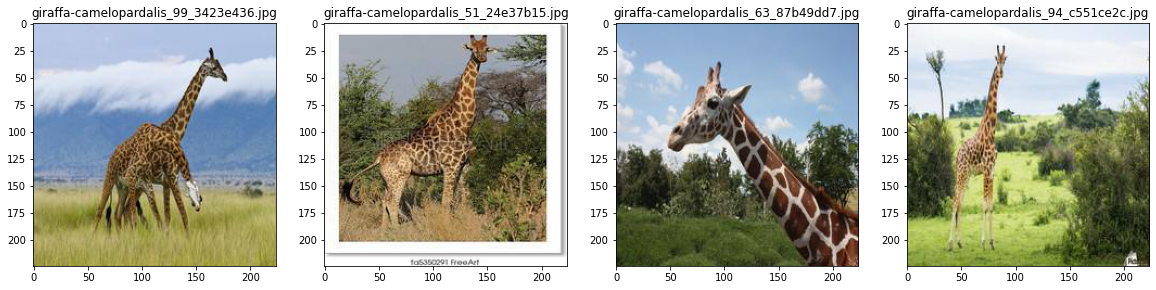

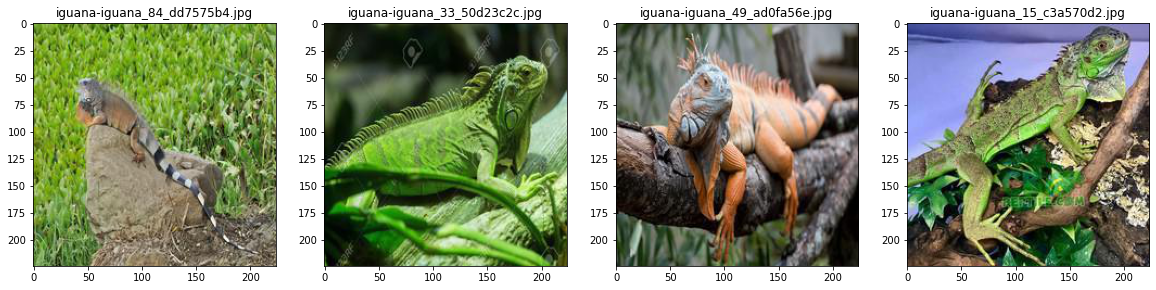

In [ ]:
# visualize randomly selected sample images for each animal species

for klas in classes:
  tmp_path = '/content/tmp/Animals/{}'.format(klas)
  plt.figure(figsize=(20,20))
  for i in range(4):
    item =random.choice(os.listdir(tmp_path))
    image_path= os.path.join(tmp_path, item)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,4,i+1)
    ax.title.set_text(item)
    plt.imshow(img)

In [ ]:
# creating new directories in each animal species folder to separately save train and test images

total_images = 0
train_images = 0
validation_images = 0

for klas in classes:
  os.makedirs(base_dir +'/train/' + klas)
  os.makedirs(base_dir +'/validation/' + klas)
  source = base_dir + '/' + klas
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)
  test_ratio = 0.10
  train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                            [int(len(allFileNames)* (1 - test_ratio))])
  
  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [source+'/' + name for name in val_FileNames.tolist()]

  total_images = total_images + len(allFileNames)
  train_images = train_images + len(train_FileNames)
  validation_images = validation_images + len(val_FileNames)
  
  for name in train_FileNames:
    shutil.copy(name, base_dir +'/train/' + klas)
  
  for name in val_FileNames:
    shutil.copy(name, base_dir +'/validation/' + klas)

print('Total images : {}'.format(total_images))
print('Total train images : {}'.format(train_images))
print('Total validation images : {}'.format(validation_images))

Total images : 66
Total train images : 58
Total validation images : 8


### 2. Image pre-processing using Tensorflow functionalities

In [ ]:
# function that pre-process the image data
# all images are re-sized to 224*224 
# all images are converted into an numpy array image

def get_data(img_folder, height, width, class_dict):
    tmp_images = []
    tmp_labels = []
   
    for directory in os.listdir(img_folder):
      files = glob.glob('{}/{}/*.jpg'.format(img_folder, directory))

      for item in files:
        image = Image.open(item).convert('RGB')
        image = np.array(image)
        #image_path = os.path.join(img_folder, directory,  item)
        #image = np.array(Image.open(image_path))
        #image= np.resize(image,(height,width,3))

        if image is None or image.shape != (height, width, 3):
          print('This file is bad image or not an image : {}'.format(item))
        else:
          tmp_images.append(image)
          tmp_labels.append(directory)
          
    images = np.array(tmp_images).astype('float')  
    target_val = [class_dict[tmp_labels[i]] for i in range(len(tmp_labels))]
    target_val = np.array(target_val).astype('float')

    return images, target_val   

In [ ]:
# developing model training data and model testing data
# images are picked from train and validation directories
# images get re-sized and converted to numpy array via function get_data() 

train_data_path = r'/content/tmp/Animals/train'
val_data_path = r'/content/tmp/Animals/validation'
resize_height = 224
resize_width = 224

X_train, Y_train = get_data(train_data_path, resize_height, resize_width, target_dict)
X_test, Y_test = get_data(val_data_path, resize_height, resize_width, target_dict)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(58, 224, 224, 3)
(58,)
(8, 224, 224, 3)
(8,)


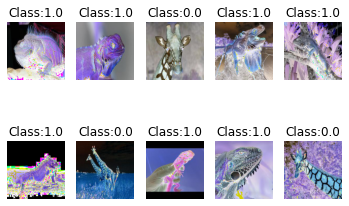

In [ ]:
# randomly selecting indexes in model training data
ridx = (random.sample([i for i in range(X_train.shape[0])], k = 10))

# visualizing pre-processed images with their Class label located at the randomly selected indexes
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    idx = ridx[i]
    plt.imshow(((X_train[idx]) * 255).astype(np.uint8))
    plt.title('Class:{}'.format(Y_train[idx]))
    plt.axis('off')
    plt.grid(True)

In [ ]:
# Create an ImageDataGenerator and do Image Augmentation
# Image Rotation, Shifting, Shearing, Flipping, Zooming applied on all model training data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.15,
                                   height_shift_range=0.15, shear_range=0.25, zoom_range=0.25,
                                   horizontal_flip=True, fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

### 3. Model development

In [ ]:
# # Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
# locate the Inception V3 model weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# define an object for InceptionV3 model. Define the input shape for the images as well
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = None)

# load downloaded weights to InceptionV3 model object
pre_trained_model.load_weights(local_weights_file)

# freezing the weights in each of the layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# visualize the pre-trained model
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
# # clear state
tf.keras.backend.clear_session()
np.random.seed(21)

In [ ]:
# select last layer from the pre-trained model : I am selecting mixed7 layer in this case

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [ ]:
# adding new layers after the 'mixed7' layer from pre-trained model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.20)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.005), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# defining other hyperparameters for model

batch_size = 4
train_steps_per_epoch = np.ceil(((X_train.shape[0])/batch_size)-1)
val_steps_per_epoch = np.ceil(((X_test.shape[0])/batch_size)-1)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train the Model
history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=batch_size), verbose=1,
                    validation_data=validation_datagen.flow(X_test, Y_test, batch_size=batch_size),
                    steps_per_epoch=train_steps_per_epoch, validation_steps=val_steps_per_epoch,
                    epochs=4, callbacks=[callback])

Epoch 1/4
14/14 [==============================] - 20s 1s/step - loss: 9.4780 - accuracy: 0.7222 - val_loss: 2.7854 - val_accuracy: 0.7500
Epoch 2/4
14/14 [==============================] - 11s 755ms/step - loss: 6.0257 - accuracy: 0.9630 - val_loss: 3.8546 - val_accuracy: 0.7500
Epoch 3/4
14/14 [==============================] - 10s 737ms/step - loss: 4.8499 - accuracy: 0.9107 - val_loss: 11.0619 - val_accuracy: 0.7500
Epoch 4/4
14/14 [==============================] - 10s 724ms/step - loss: 1.7300 - accuracy: 0.9815 - val_loss: 4.2884e-15 - val_accuracy: 1.0000


### 4. Model Evaluation

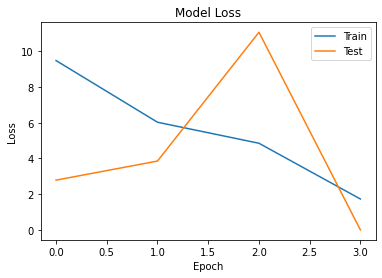

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

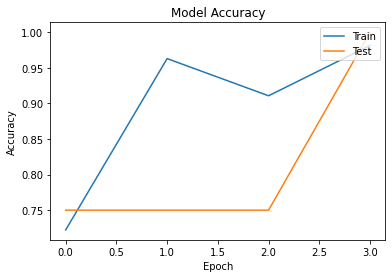

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()